In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.python.keras import regularizers
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D
import os
from PIL import Image, ImageOps

In [2]:
x_dir='/home/sahankj/Practice/Major_Project/My_Dataset_Generalised/Train/Image/' 
y_dir='/home/sahankj/Practice/Major_Project/My_Dataset_Generalised/Train/Label/'
x_test_dir='/home/sahankj/Practice/Major_Project/My_Dataset_Generalised/Test/Image/' 
y_test_dir='/home/sahankj/Practice/Major_Project/My_Dataset_Generalised/Test/Label/'

ls = os.listdir(x_dir)
test_ls = os.listdir(x_test_dir)

data_ls = []
for each in ls:
    image = np.array(Image.open(x_dir+each))
    data_ls.append(image)
x_train = np.array(data_ls)

data_ls = []
for each in ls:
    image = np.array(Image.open(y_dir+each))
    if image.shape == (512, 512, 3):
        image = np.array(ImageOps.grayscale(Image.open(y_dir+each)))
    data_ls.append(image.reshape(512, 512, 1))
y_train = np.array(data_ls)

data_ls = []
for each in test_ls:
    image = np.array(Image.open(x_test_dir+each))
    data_ls.append(image)
x_test = np.array(data_ls)

data_ls = []
for each in test_ls:
    image = np.array(Image.open(y_test_dir+each))
    if image.shape == (512, 512, 3):
        image = np.array(ImageOps.grayscale(Image.open(y_test_dir+each)))
    data_ls.append(image.reshape(512, 512, 1))
y_test = np.array(data_ls)

x_train, y_train, x_test, y_test = x_train/255.0, y_train/255.0, x_test/255.0, y_test/255.0

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(288, 512, 512, 3)
(288, 512, 512, 1)
(58, 512, 512, 3)
(58, 512, 512, 1)


In [5]:
import os
os.path

<module 'posixpath' from '/usr/lib/python3.9/posixpath.py'>

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (512,512,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
cnn.add(Dense(32, activation='softmax'))
cnn.add(Dense(1, activation='softmax'))
cnn.summary()

In [ ]:
def gen(batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    for name in ls:
        x_batch = []
        y_batch = []
        for b in range(batch_size):
            if i == len(ls):
                i = 0
            image = np.array(Image.open(x_dir+name))
            #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = image/255.0
            '''if image.shape == (512,512,3):
                image = np.array(ImageOps.grayscale(Image.open(x_dir+name)))'''
            x_batch.append(image.reshape(512,512,3))
            image = np.array(Image.open(y_dir+name))
            image = image/255.0
            if image.shape == (512,512,3):
                image = np.array(ImageOps.grayscale(Image.open(x_dir+name)))
            y_batch.append(image.reshape(512,512,1))

            i+=1

        yield np.array(x_batch),np.array(y_batch)

In [ ]:
cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
#history = cnn.fit(x_train[:20], y_train[:20], batch_size=8, epochs=30, validation_split=0.1)
history = cnn.fit(gen(16),steps_per_epoch=100,epochs=3,TF_GPU_ALLOCATOR=cuda_malloc_async)  # steps_per_epoch=len(ls)/batch_size to iterate through full dataset for one epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
### origin
encoder_input = keras.Input(shape=(512,512,1),name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(512, activation='relu')(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')



y = keras.layers.Dense(512,activation='relu')(encoder_output)

decoder_input = keras.layers.Dense(262144,activation='relu')(y)
decoder_output = keras.layers.Reshape((512,512,1))(decoder_input)

opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)

autoencoder = keras.Model(encoder_input,decoder_output,name='autoencoder')
autoencoder.summary()

In [4]:
## current

encoder_input = keras.Input(shape=(512,512,3),name='img')
l1 = keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
                         activity_regularizer = regularizers.l1(10e-10))(encoder_input)
#l2 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(l1)
l2 = keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)
#l4 = keras.layers.UpSampling2D()(l3)
l3 = keras.layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l2)

l4 = keras.layers.Conv2D(8, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

decoder_output = keras.layers.Conv2D(1, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)
'''
l5 = keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)
l6 = keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l5)
l7 = keras.layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)
l8 = keras.layers.Conv2D(1, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l7)'''

opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)

autoencoder = keras.Model(encoder_input,decoder_output,name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 512, 32)      18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 512, 16)      4624      
                                                                 
 conv2d_8 (Conv2D)           (None, 512, 512, 8)       1160      
                                                                 
 conv2d_9 (Conv2D)           (None, 512, 512, 1)       73        
                                                                 
Total params: 26,113
Trainable params: 26,113
Non-train

In [5]:
checkpoint_path = "/home/sahankj/Practice/Major_Project/ckpt/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [6]:
autoencoder.compile(loss='mse')
autoencoder.fit(x_train,y_train,epochs=2500,batch_size=2,validation_split=0.1,callbacks=[cp_callback])

2022-05-07 22:24:15.702295: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 814743552 exceeds 10% of free system memory.
2022-05-07 22:24:16.843056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 271581184 exceeds 10% of free system memory.
2022-05-07 22:24:17.210190: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 814743552 exceeds 10% of free system memory.
2022-05-07 22:24:17.658654: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 271581184 exceeds 10% of free system memory.


Epoch 1/2500


2022-05-07 22:24:20.036600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-05-07 22:24:21.886979: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-07 22:24:21.887569: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-07 22:24:21.978306: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

130/130 [==============================] - ETA: 0s - loss: 0.0547

2022-05-07 22:24:37.300752: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 91226112 exceeds 10% of free system memory.



Epoch 00001: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 20s 114ms/step - loss: 0.0547 - val_loss: 0.0511
Epoch 2/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0445
Epoch 00002: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 94ms/step - loss: 0.0445 - val_loss: 0.0397
Epoch 3/2500
130/130 [==============================] - ETA: 0s - loss: 0.0379
Epoch 00003: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0379 - val_loss: 0.0350
Epoch 4/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0360
Epoch 00004: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0360 - val_loss: 0.0329
Epoch 5/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0345
Ep

Epoch 67/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0263
Epoch 00067: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 92ms/step - loss: 0.0263 - val_loss: 0.0261
Epoch 68/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0261
Epoch 00068: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 92ms/step - loss: 0.0261 - val_loss: 0.0277
Epoch 69/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0263
Epoch 00069: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0263 - val_loss: 0.0275
Epoch 70/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0261
Epoch 00070: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0261 - val_loss: 0.0276


Epoch 100/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0254
Epoch 00100: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0254 - val_loss: 0.0260
Epoch 101/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0254
Epoch 00101: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0254 - val_loss: 0.0266
Epoch 102/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0254
Epoch 00102: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 103/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0253
Epoch 00103: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0254 - val_loss: 0.0

Epoch 133/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 00133: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0250 - val_loss: 0.0251
Epoch 134/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 00134: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0249 - val_loss: 0.0289
Epoch 135/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 00135: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0250 - val_loss: 0.0254
Epoch 136/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0249
Epoch 00136: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0249 - val_loss: 0.0

Epoch 166/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0247
Epoch 00166: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0246 - val_loss: 0.0249
Epoch 167/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 00167: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0247 - val_loss: 0.0267
Epoch 168/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0247
Epoch 00168: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 169/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 00169: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0246 - val_loss: 0.0

Epoch 199/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0245
Epoch 00199: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0245 - val_loss: 0.0251
Epoch 200/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0244
Epoch 00200: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0244 - val_loss: 0.0260
Epoch 201/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0244
Epoch 00201: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 202/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0244
Epoch 00202: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0244 - val_loss: 0.0

Epoch 232/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0242
Epoch 00232: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0242 - val_loss: 0.0248
Epoch 233/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0243
Epoch 00233: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0242 - val_loss: 0.0318
Epoch 234/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0243
Epoch 00234: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0243 - val_loss: 0.0245
Epoch 235/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0242
Epoch 00235: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0241 - val_loss: 0.0

Epoch 265/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0242
Epoch 00265: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0242 - val_loss: 0.0253
Epoch 266/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0239
Epoch 00266: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0239 - val_loss: 0.0267
Epoch 267/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0242
Epoch 00267: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0241 - val_loss: 0.0254
Epoch 268/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 00268: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0241 - val_loss: 0.0

Epoch 298/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0240
Epoch 00298: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0240 - val_loss: 0.0244
Epoch 299/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0239
Epoch 00299: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0239 - val_loss: 0.0246
Epoch 300/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0240
Epoch 00300: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0240 - val_loss: 0.0245
Epoch 301/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0240
Epoch 00301: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0241 - val_loss: 0.0

Epoch 331/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0239
Epoch 00331: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0239 - val_loss: 0.0237
Epoch 332/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00332: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0238 - val_loss: 0.0243
Epoch 333/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00333: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 334/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00334: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0238 - val_loss: 0.0

Epoch 364/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00364: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0238 - val_loss: 0.0242
Epoch 365/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00365: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0237 - val_loss: 0.0245
Epoch 366/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00366: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0237 - val_loss: 0.0241
Epoch 367/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 00367: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0237 - val_loss: 0.0

Epoch 397/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00397: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0236 - val_loss: 0.0240
Epoch 398/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 00398: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0237 - val_loss: 0.0243
Epoch 399/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00399: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0236 - val_loss: 0.0237
Epoch 400/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00400: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0236 - val_loss: 0.0

Epoch 430/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00430: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0266
Epoch 431/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00431: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0244
Epoch 432/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00432: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0236 - val_loss: 0.0249
Epoch 433/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00433: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0

Epoch 463/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00463: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0242
Epoch 464/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00464: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0243
Epoch 465/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00465: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0236 - val_loss: 0.0238
Epoch 466/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00466: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0

Epoch 496/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00496: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0240
Epoch 497/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00497: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 498/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00498: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0250
Epoch 499/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00499: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0

Epoch 529/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00529: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0250
Epoch 530/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00530: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0260
Epoch 531/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00531: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 532/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00532: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0

Epoch 562/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00562: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0238
Epoch 563/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00563: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0240
Epoch 564/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00564: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0236
Epoch 565/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00565: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0235 - val_loss: 0.0

Epoch 595/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00595: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 596/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00596: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 597/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00597: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0253
Epoch 598/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00598: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0

Epoch 628/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00628: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0239
Epoch 629/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00629: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0248
Epoch 630/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00630: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0236
Epoch 631/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00631: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0

Epoch 661/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00661: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0246
Epoch 662/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00662: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0238
Epoch 663/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00663: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 664/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00664: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0

Epoch 694/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00694: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0249
Epoch 695/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00695: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0241
Epoch 696/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00696: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0233
Epoch 697/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00697: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0

Epoch 727/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 00727: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0234 - val_loss: 0.0248
Epoch 728/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00728: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0237
Epoch 729/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00729: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0246
Epoch 730/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00730: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0232 - val_loss: 0.0

Epoch 760/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00760: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0249
Epoch 761/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00761: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0253
Epoch 762/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00762: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0234
Epoch 763/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00763: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0

Epoch 793/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00793: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0252
Epoch 794/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00794: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0237
Epoch 795/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00795: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0237
Epoch 796/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 00796: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0

Epoch 826/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00826: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0239
Epoch 827/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00827: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0240
Epoch 828/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00828: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 829/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00829: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0

Epoch 859/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00859: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0242
Epoch 860/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 00860: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0257
Epoch 861/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00861: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0239
Epoch 862/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00862: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0

Epoch 892/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00892: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0238
Epoch 893/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00893: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 894/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00894: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0245
Epoch 895/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00895: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0

Epoch 925/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00925: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0241
Epoch 926/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00926: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0245
Epoch 927/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00927: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0238
Epoch 928/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00928: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0

Epoch 958/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00958: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0244
Epoch 959/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00959: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0253
Epoch 960/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 00960: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 961/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00961: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0

Epoch 991/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00991: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0239
Epoch 992/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00992: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0239
Epoch 993/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00993: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0245
Epoch 994/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00994: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0

Epoch 1024/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01024: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 1025/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01025: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0275
Epoch 1026/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 01026: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0241
Epoch 1027/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01027: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss:

Epoch 1057/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01057: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0237
Epoch 1058/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01058: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0240
Epoch 1059/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 01059: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 1060/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 01060: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss:

Epoch 1090/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01090: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 1091/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01091: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0256
Epoch 1092/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01092: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0254
Epoch 1093/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01093: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss:

Epoch 1123/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 01123: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 1124/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01124: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 1125/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01125: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 1126/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01126: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss:

Epoch 1156/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01156: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 1157/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01157: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0238
Epoch 1158/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01158: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 1159/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01159: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1189/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01189: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0236
Epoch 1190/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01190: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 1191/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01191: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0240
Epoch 1192/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01192: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1222/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01222: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 1223/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01223: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1224/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01224: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0244
Epoch 1225/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01225: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss:

Epoch 1255/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01255: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0248
Epoch 1256/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01256: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0249
Epoch 1257/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01257: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0238
Epoch 1258/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01258: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1288/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01288: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 1289/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01289: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0246
Epoch 1290/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01290: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 1291/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01291: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1321/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01321: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 1322/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01322: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0237
Epoch 1323/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01323: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0237
Epoch 1324/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01324: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1354/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01354: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1355/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01355: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 1356/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01356: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 1357/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01357: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1387/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01387: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0242
Epoch 1388/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01388: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0239
Epoch 1389/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01389: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0239
Epoch 1390/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01390: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1420/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01420: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1421/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01421: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 1422/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01422: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 1423/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01423: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss:

Epoch 1453/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01453: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 1454/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01454: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0240
Epoch 1455/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01455: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1456/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01456: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1486/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01486: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0238
Epoch 1487/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01487: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0236
Epoch 1488/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 01488: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0229 - val_loss: 0.0236
Epoch 1489/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01489: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1519/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01519: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1520/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01520: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 1521/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01521: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0253
Epoch 1522/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01522: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1552/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01552: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 1553/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01553: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 1554/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01554: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 1555/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01555: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1585/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01585: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0236
Epoch 1586/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01586: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0233
Epoch 1587/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01587: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 1588/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01588: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1618/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01618: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 1619/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01619: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0239
Epoch 1620/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01620: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0237
Epoch 1621/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01621: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1651/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01651: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 1652/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01652: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 1653/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01653: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0238
Epoch 1654/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01654: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1684/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01684: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0240
Epoch 1685/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01685: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0242
Epoch 1686/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01686: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 1687/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01687: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1717/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01717: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0240
Epoch 1718/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01718: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0251
Epoch 1719/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01719: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 1720/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01720: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1750/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01750: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0235
Epoch 1751/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01751: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0241
Epoch 1752/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01752: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0260
Epoch 1753/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01753: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss:

Epoch 1783/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01783: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0252
Epoch 1784/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01784: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0244
Epoch 1785/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01785: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 1786/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01786: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1816/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01816: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 1817/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01817: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 1818/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01818: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 1819/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01819: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1849/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01849: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0235
Epoch 1850/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01850: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 1851/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01851: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0249
Epoch 1852/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01852: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1882/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01882: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0244
Epoch 1883/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01883: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0264
Epoch 1884/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01884: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0241
Epoch 1885/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01885: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 1915/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01915: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 1916/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01916: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0238
Epoch 1917/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01917: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0250
Epoch 1918/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01918: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 1948/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01948: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0232
Epoch 1949/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01949: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 1950/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01950: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0245
Epoch 1951/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01951: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 1981/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 01981: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0239
Epoch 1982/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 01982: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0241
Epoch 1983/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01983: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0235
Epoch 1984/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 01984: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2014/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02014: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 2015/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02015: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 2016/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02016: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0238
Epoch 2017/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02017: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2047/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02047: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0236
Epoch 2048/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02048: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0236
Epoch 2049/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02049: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0241
Epoch 2050/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02050: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2080/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02080: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0245
Epoch 2081/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02081: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0246
Epoch 2082/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02082: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 2083/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02083: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2113/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02113: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 2114/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02114: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 2115/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02115: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0243
Epoch 2116/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02116: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2146/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02146: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0238
Epoch 2147/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02147: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 2148/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02148: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 2149/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02149: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 2179/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02179: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 2180/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02180: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0238
Epoch 2181/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02181: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 2182/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 02182: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0225 - val_loss:

Epoch 2212/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 02212: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0225 - val_loss: 0.0238
Epoch 2213/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02213: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0248
Epoch 2214/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02214: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0234
Epoch 2215/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02215: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 2245/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02245: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0241
Epoch 2246/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02246: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0228 - val_loss: 0.0237
Epoch 2247/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02247: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0237
Epoch 2248/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02248: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 2278/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02278: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 2279/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02279: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0231
Epoch 2280/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02280: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0225 - val_loss: 0.0238
Epoch 2281/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 02281: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss:

Epoch 2311/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02311: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0234
Epoch 2312/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02312: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0242
Epoch 2313/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02313: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0233
Epoch 2314/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02314: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2344/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 02344: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0225 - val_loss: 0.0240
Epoch 2345/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02345: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0231
Epoch 2346/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 02346: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0226 - val_loss: 0.0237
Epoch 2347/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 02347: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 89ms/step - loss: 0.0227 - val_loss:

Epoch 2377/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02377: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 95ms/step - loss: 0.0226 - val_loss: 0.0251
Epoch 2378/2500
130/130 [==============================] - ETA: 0s - loss: 0.0226
Epoch 02378: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0226 - val_loss: 0.0242
Epoch 2379/2500
130/130 [==============================] - ETA: 0s - loss: 0.0226
Epoch 02379: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0226 - val_loss: 0.0241
Epoch 2380/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02380: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0226 - val_loss:

Epoch 2410/2500
129/130 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 02410: saving model to /home/sahankj/Practice/Major_Project/ckpt/cp.ckpt
130/130 [==============================] - 12s 93ms/step - loss: 0.0226 - val_loss: 0.0237
Epoch 2411/2500
 24/130 [====>.........................] - ETA: 9s - loss: 0.0221

KeyboardInterrupt: 

In [7]:
## load model
autoencoder.load_weights('/home/sahankj/Practice/Major_Project/ckpt/cp.ckpt')


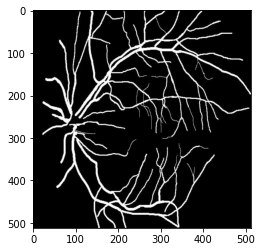

In [11]:
count = 8
plt.imshow(y_train[count].reshape(512,512),cmap='gray')

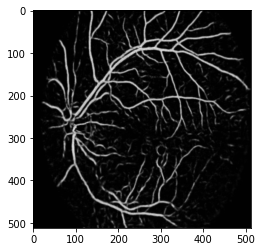

In [12]:
# prediction

example = autoencoder.predict([x_train[count].reshape(-1,512,512,3)])[0]
plt.imshow(example.reshape((512,512)),cmap='gray')

In [19]:
image = np.array(Image.open('test.jpg'))
image = image/255.0
image = autoencoder.predict(image.reshape(-1,512,512,3))[0]
image = image.reshape((512,512))
image = Image.fromarray(image.astype('uint8'), 'L')
type(image)

PIL.Image.Image